# Klachten Dataset Project 1
## Data Voorbereiding 
Versie Mattijn

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from pathlib import Path
from typing import Dict, List, Tuple

from sklearn import tree
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    mean_absolute_error,
    r2_score,
    root_mean_squared_error,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from wordcloud import WordCloud


In [2]:
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Matti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Matti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Matti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Matti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Matti\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
klachten = pd.read_csv("klachten.csv")

In [4]:
klachten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14887 entries, 0 to 14886
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                14887 non-null  int64 
 1   Datum_ontvangst   14887 non-null  object
 2   Product           14887 non-null  object
 3   Omschrijving      14887 non-null  object
 4   Antwoord_bedrijf  14887 non-null  object
dtypes: int64(1), object(4)
memory usage: 581.7+ KB


## Train-Test Splits maken

In [5]:
X = klachten["Omschrijving"].astype(str)
y = klachten["Product"].astype(str)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(10420,) (4467,)
(10420,) (4467,)


## Data Processing

In [6]:
def remove_punctuation(text: str) -> str:
    """Haal leestekens weg."""
    return re.sub(r"[^\w\s]", "", text)

# stopwoordenlijst & lemmatizer als globale objecten
stop_words = set(stopwords.words("english"))
extra_stopwords = {
    "xxxx", "xx", "xx xx", "xxxx xxxx", "xx xxxx", "n", "xxxxxxxx2007", "XXXX", "XXXX  XXXX"
    "s", "n't", "told", "u", "help", "call", "xxxxxxxxxxxx", "xxxxxxxx", "XX XX"  "x", "X"
}
stop_words = stop_words.union(extra_stopwords)

lemmatizer = WordNetLemmatizer()

def has_multiple_x(word: str) -> bool:
    """Return True als een woord meer dan 1 'x' bevat (case-insensitive)."""
    return word.lower().count("x") > 1

def data_preprocessor(text: str) -> str:
    """Lowercase + leestekens weghalen."""
    text = text.lower()
    text = remove_punctuation(text)
    return text

def data_tokenizer(text: str):
    """
    1. Tokenizen
        2. Stopwoorden verwijderen
        3. Lemmatizen
        """
        # 1. tokenizen
    tokens = word_tokenize(text, language="english")

    # 2. stopwoorden en woorden met >1 x verwijderen
    tokens = [
        t for t in tokens
        if t not in stop_words and not has_multiple_x(t)
    ]


    # 3. lemmatizen (LET OP: .lemmatize, niet .lamatize)
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    print(tokens)
    return tokens

In [7]:
with open("stopwords.txt", "w", encoding="utf-8") as f:
    for word in sorted(stop_words):      # sorted = mooi alfabetisch
        f.write(word + "\n")


In [8]:
vectorizer = TfidfVectorizer(
    lowercase=False,
    preprocessor=data_preprocessor,
    tokenizer=data_tokenizer,
    analyzer="word",
    stop_words=None,
    token_pattern=None
)

X_train_tfidf = vectorizer.fit_transform(X_train)

print("\nVorm van de TF-IDF-matrix:", X_train_tfidf.shape)
print("Features (woorden):", vectorizer.get_feature_names_out())

['received', 'copy', 'credit', 'report', 'state', 'judgment', 'know', 'got', 'judgement', 'never', 'given', 'notice', 'appear', 'court']
['paid', '42000', 'appraisal', 'home', 'based', 'upon', 'rate', 'originally', 'quoted', 'mortgage', 'finance', 'america', 'mortgage', 'dba', 'document', 'mortgage', 'provided', 'quoted', 'rate', 'higher', 'elected', 'go', 'different', 'brokerlender', 'division', 'requested', 'appraisal', 'transferred', 'since', 'paid', 'respond', 'several', 'week', 'uncooperative', 'would', 'provide', 'necessary', 'paperwork']
['transunion', 'reporting', 'credit', 'report', 'transaction', 'initiated', 'towed', 'vehicle', 'sold', 'transunion', 'finex', 'group', 'standing', 'reporting', 'anything', 'credit', 'report', 'since', 'initiated']
['begin', 'prior', 'entering', 'vehicle', 'loan', 'agreement', 'tdauto', 'fiance', 'conjunction', 'previous', 'vehicle', 'stolen', 'college', 'parttime', 'job', 'per', 'week', 'dire', 'need', 'vehicle', 'high', 'demand', 'daytoday', '

### Datum exploration Grafiek

In [9]:
klachten["Datum_ontvangst"] = pd.to_datetime(klachten["Datum_ontvangst"])


Aantal klachten per dag

In [10]:
per_dag = (
    klachten
    .set_index("Datum_ontvangst") 
    .resample("D")                 
    .size()                        
    .rename("aantal_klachten")
    .reset_index()
)

Grafieken met de data

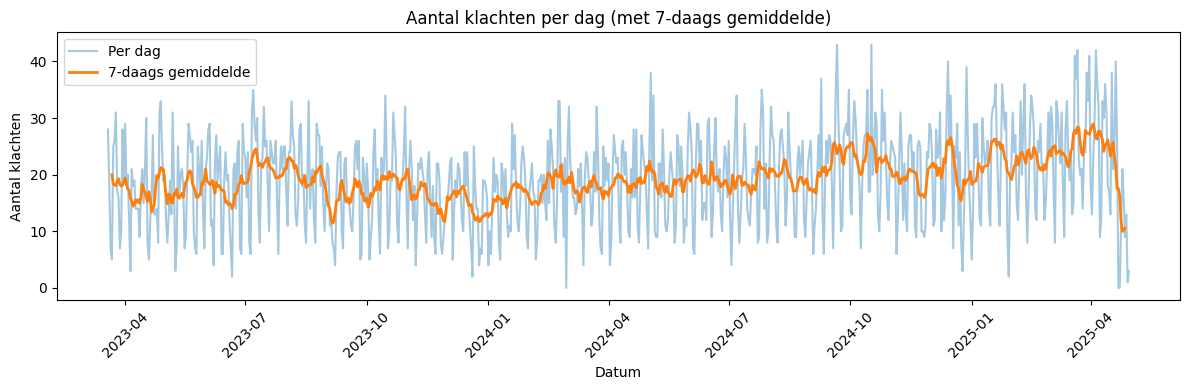

In [11]:
per_dag["rolling_7"] = per_dag["aantal_klachten"].rolling(7, center=True).mean()

plt.figure(figsize=(12, 4))
plt.plot(per_dag["Datum_ontvangst"], per_dag["aantal_klachten"], alpha=0.4, label="Per dag")
plt.plot(per_dag["Datum_ontvangst"], per_dag["rolling_7"], linewidth=2, label="7-daags gemiddelde")
plt.title("Aantal klachten per dag (met 7-daags gemiddelde)")
plt.xlabel("Datum")
plt.ylabel("Aantal klachten")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

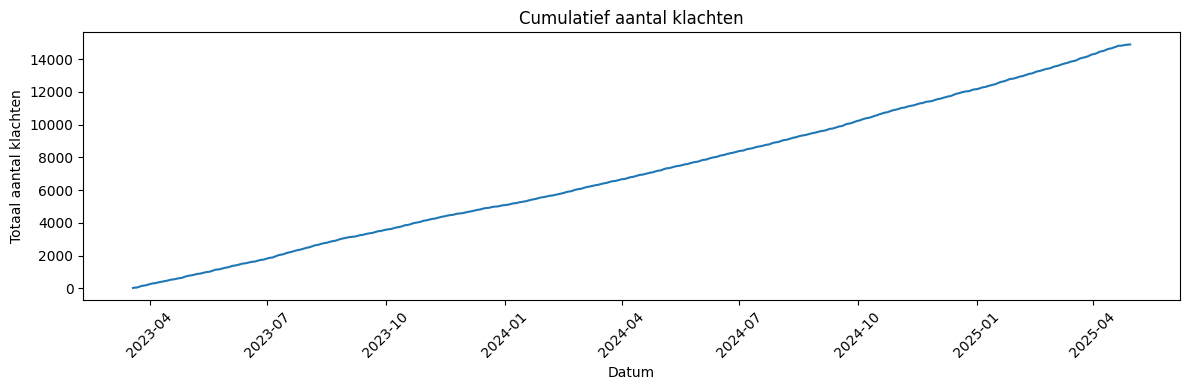

In [12]:
per_dag["cumulatief"] = per_dag["aantal_klachten"].cumsum()

plt.figure(figsize=(12, 4))
plt.plot(per_dag["Datum_ontvangst"], per_dag["cumulatief"])
plt.title("Cumulatief aantal klachten")
plt.xlabel("Datum")
plt.ylabel("Totaal aantal klachten")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


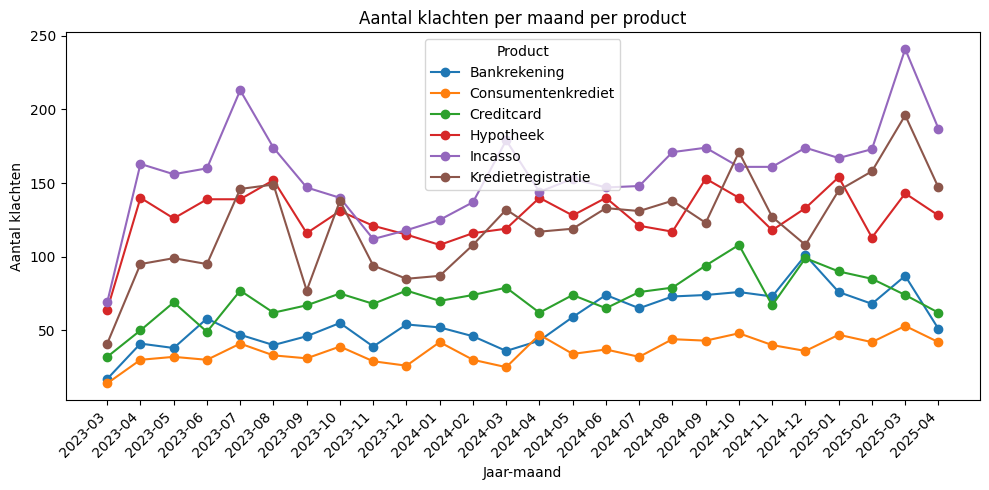

In [13]:
klachten["jaar"] = klachten["Datum_ontvangst"].dt.year
klachten["maand"] = klachten["Datum_ontvangst"].dt.month

per_maand_product = (
    klachten
    .groupby(["jaar", "maand", "Product"])
    .size()
    .rename("aantal_klachten")
    .reset_index()
)

per_maand_product["jaar_maand"] = (
    per_maand_product["jaar"].astype(str) + "-" +
    per_maand_product["maand"].astype(str).str.zfill(2)
)


plt.figure(figsize=(10,5))

for product, subdf in per_maand_product.groupby("Product"):
    plt.plot(subdf["jaar_maand"], subdf["aantal_klachten"], marker="o", label=product)

plt.title("Aantal klachten per maand per product")
plt.xlabel("Jaar-maand")
plt.ylabel("Aantal klachten")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Product")
plt.tight_layout()
plt.show()

In [14]:
klachten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14887 entries, 0 to 14886
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID                14887 non-null  int64         
 1   Datum_ontvangst   14887 non-null  datetime64[ns]
 2   Product           14887 non-null  object        
 3   Omschrijving      14887 non-null  object        
 4   Antwoord_bedrijf  14887 non-null  object        
 5   jaar              14887 non-null  int32         
 6   maand             14887 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(1), object(3)
memory usage: 698.0+ KB


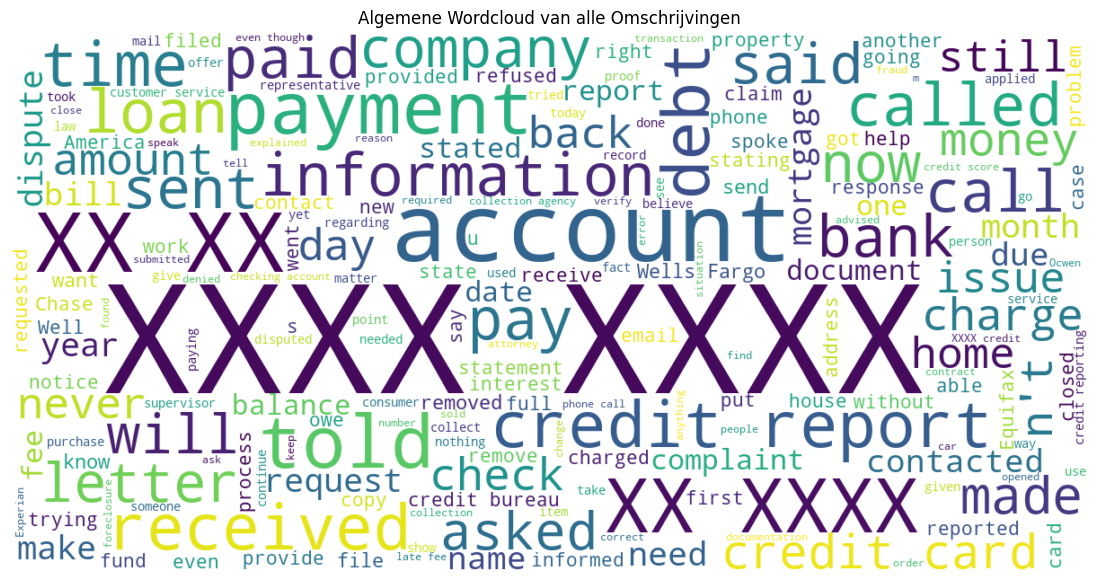

In [ ]:
text_all = " ".join(klachten["Omschrijving"].astype(str))

wc = WordCloud(
    background_color="white",
    max_words=200,
    width=1200,
    height=600
).generate(text_all)

plt.figure(figsize=(14,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Algemene Wordcloud van alle Omschrijvingen")
plt.show()
